In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn=warn
warnings.filterwarnings('ignore')

from itertools import product
def permutations_with_replacement(n, m):
    for i in product(list(range(1, m + 1)), repeat=n):
        yield i

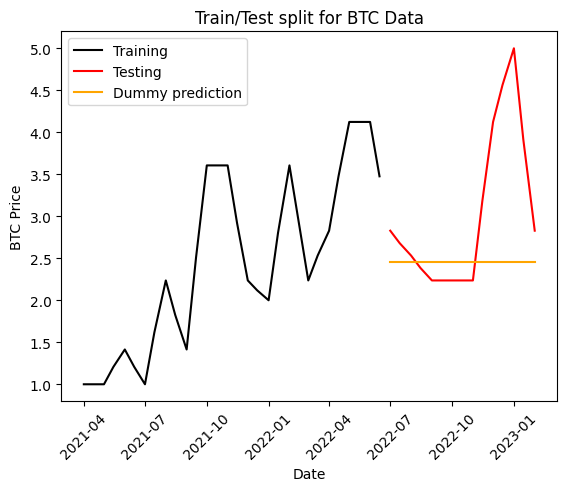

In [2]:
data=pd.read_excel('friday.xlsx', index_col=None, header=None, sheet_name='Лист4', nrows=9, skiprows=[0, 1, 3], usecols='B,D:X')
df=data.T
df.columns=df.loc[1]
df.drop(index=1, inplace=True)

df.rename(columns={'№ точки':'time'}, inplace=True)
df.reset_index(drop=True, inplace=True)
df.time=df.time.apply(lambda x: x.strftime('%Y-%m'))

df.index = pd.DatetimeIndex(data=df.time, freq='infer')
df.drop(columns='time', inplace=True)
df.columns=[s.strip() for s in df.columns]
df.columns.name='points'
df=df.astype(float)

# df_addition=df.iloc[15:17].mean().to_frame().T
# df_addition.index=pd.DatetimeIndex(data=['2022-08'])
# df=pd.concat([df, df_addition]).sort_index()
df=df.asfreq('SMS')
df.interpolate(axis=0, inplace=True)
uno_punto=df['1-5']

train = uno_punto[uno_punto.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test = uno_punto[uno_punto.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]

dummy_pred=pd.Series(np.full((test.shape),train.mean(),dtype=float))
dummy_pred.index=test.index

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

In [3]:
dummy_rmse = np.sqrt(mean_squared_error(test.values, dummy_pred.values))
print("Dummy RMSE: ",dummy_rmse)

Dummy RMSE:  1.0603432895421567


In [4]:
seasonal_orders=list(permutations_with_replacement(4, 5))
orders=list(permutations_with_replacement(3, 5))

In [5]:
cv_results=pd.DataFrame()
cv_results['seasonal_orders']=seasonal_orders
ordrs=np.tile(orders, (len(seasonal_orders), 1)).reshape((len(seasonal_orders),len(orders), 3)).tolist()
ordrs=[[tuple(el) for el in l] for l in ordrs]
cv_results['orders']=ordrs
cv_results=cv_results.explode(column='orders').sort_values(by=['seasonal_orders','orders']).reset_index(drop=True)
results=pd.Series(np.full((cv_results.shape[0],),100000,dtype=float))

In [6]:
cv_results_first_half=cv_results.iloc[:39000]
results_first_half=results[:39000]

12000 seconds...

In [12]:
for (index, (s_ordr, ordr)) in cv_results_first_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=200)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_first_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [13]:
cv_results_first_half['results']=results_first_half

In [14]:
sorttt=cv_results_first_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [24]:
sorttt.tail(230)

,seasonal_orders,orders,results
38770,"(1, 1, 5, 4)","(1, 2, 2)",1.060728
38771,"(1, 1, 5, 4)","(1, 2, 3)",1.059330
38772,"(1, 1, 5, 5)","(2, 2, 4)",1.056458
38773,"(2, 2, 1, 5)","(4, 1, 1)",1.056092
38774,"(2, 2, 3, 5)","(2, 1, 2)",1.053983
...,...,...,...
38995,"(2, 2, 1, 5)","(2, 1, 4)",0.793113
38996,"(2, 2, 1, 5)","(3, 1, 3)",0.790433
38997,"(2, 2, 1, 5)","(2, 1, 3)",0.789339
38998,"(1, 1, 2, 5)","(1, 1, 1)",0.743289


In [25]:
sorttt.tail(230).to_csv('1-5'+'_half_1.csv')

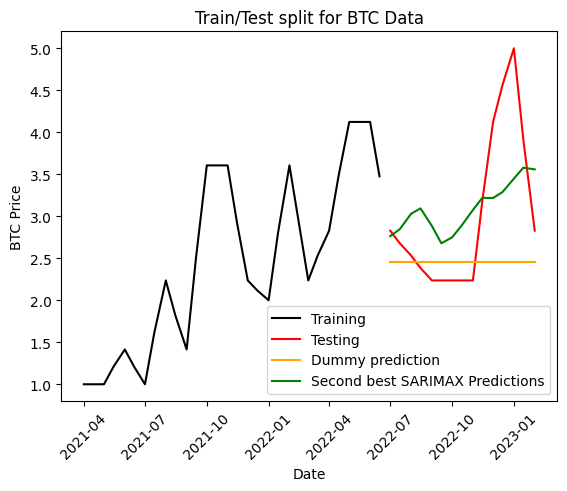

In [17]:
SARIMAXmodel = SARIMAX(train, order = (1, 1, 1), seasonal_order=(1, 1, 2, 5), enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
srmx_y_pred_df.index = test.index
y_pred_out = srmx_y_pred_df["Predictions"] 



plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.plot(y_pred_out, color='green', label = 'Second best SARIMAX Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

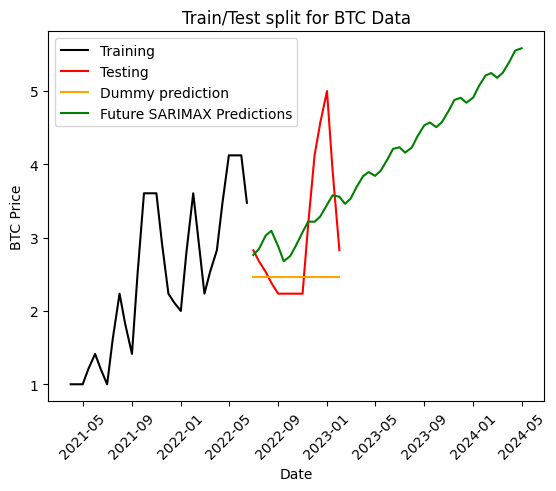

In [18]:
SARIMAXmodel = SARIMAX(train, order = (1, 1, 1), seasonal_order=(1, 1, 2, 5), enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index)*3)
srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
y_pred_out = srmx_y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.plot(y_pred_out, color='green', label = 'Future SARIMAX Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

### WRONG! THAT was an np ARRAY NOT A SERIES!!!!!!!

In [7]:
cv_results_second_half=cv_results.iloc[39000:]
results_second_half=results[39000:]

In [8]:
results_second_half

39000    100000.0
39001    100000.0
39002    100000.0
39003    100000.0
39004    100000.0
           ...   
78120    100000.0
78121    100000.0
78122    100000.0
78123    100000.0
78124    100000.0
Length: 39125, dtype: float64

24000 seconds!!!

no, just 15900 seconds...

In [9]:
for (index, (s_ordr, ordr)) in cv_results_second_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_second_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000


In [11]:
cv_results_second_half['results']=results_second_half

In [12]:
sorttt=cv_results_second_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [14]:
sorttt.tail(40)

,seasonal_orders,orders,results
39085,"(5, 1, 4, 5)","(1, 2, 4)",1.062436
39086,"(4, 1, 1, 3)","(2, 2, 2)",1.059675
39087,"(4, 1, 1, 3)","(1, 1, 1)",1.057371
39088,"(5, 1, 5, 4)","(2, 1, 3)",1.057183
39089,"(4, 1, 4, 5)","(4, 3, 3)",1.056388
39090,"(5, 1, 5, 5)","(1, 2, 4)",1.054019
39091,"(4, 2, 5, 2)","(1, 1, 1)",1.043771
39092,"(4, 1, 5, 2)","(1, 2, 1)",1.043359
39093,"(4, 1, 1, 5)","(4, 3, 3)",1.030778
39094,"(5, 1, 2, 5)","(1, 2, 4)",1.024874


In [16]:
sorttt.tail(40).to_csv('1-5'+'_half_2.csv')

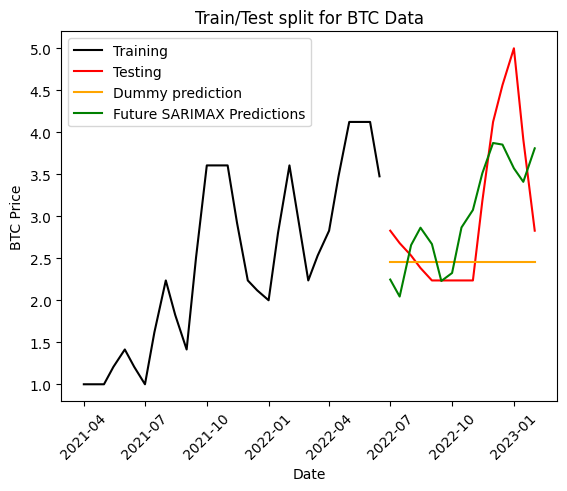

In [17]:
SARIMAXmodel = SARIMAX(train, order = (1, 1, 1), seasonal_order=(4, 1, 1, 5), enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit(maxiter=200)
srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))
srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
y_pred_out = srmx_y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.plot(y_pred_out, color='green', label = 'Future SARIMAX Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

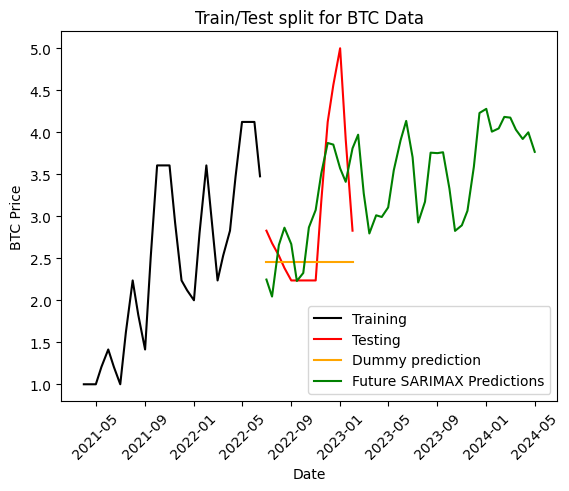

In [18]:
SARIMAXmodel = SARIMAX(train, order = (1, 1, 1), seasonal_order=(4, 1, 1, 5), enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index)*3)
srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
y_pred_out = srmx_y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.plot(y_pred_out, color='green', label = 'Future SARIMAX Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

THE ABOVE ONE IS PRETTY GOOD WOO

bad one from that dumb search

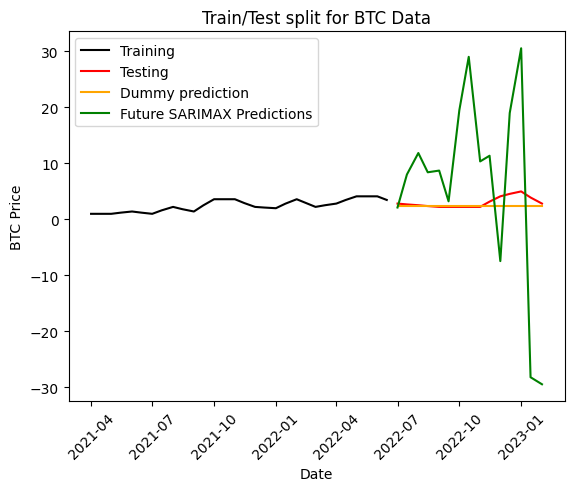

In [19]:
SARIMAXmodel = SARIMAX(train, order = (1, 1, 1), seasonal_order=(5, 5, 5, 5), enforce_invertibility=False)
SARIMAXmodel = SARIMAXmodel.fit(maxiter=200)
srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))
srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
y_pred_out = srmx_y_pred_df["Predictions"] 
plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.plot(y_pred_out, color='green', label = 'Future SARIMAX Predictions')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

## need to check only those containing 1.

In [5]:
len(seasonal_orders)

625

In [6]:

def contains_one(el):
    return 1 in el;
seasonal_orders_series=pd.Series(seasonal_orders)
seasonal_orders_series[seasonal_orders_series.apply(contains_one)]

0      (1, 1, 1, 1)
1      (1, 1, 1, 2)
2      (1, 1, 1, 3)
3      (1, 1, 1, 4)
4      (1, 1, 1, 5)
           ...     
604    (5, 5, 1, 5)
605    (5, 5, 2, 1)
610    (5, 5, 3, 1)
615    (5, 5, 4, 1)
620    (5, 5, 5, 1)
Length: 369, dtype: object

In [7]:
soord=list(permutations_with_replacement(4, 8))
len(soord)

4096

In [8]:
seasonal_orders_series=pd.Series(soord)
seasonal_orders_series[seasonal_orders_series.apply(contains_one)]

0       (1, 1, 1, 1)
1       (1, 1, 1, 2)
2       (1, 1, 1, 3)
3       (1, 1, 1, 4)
4       (1, 1, 1, 5)
            ...     
4056    (8, 8, 4, 1)
4064    (8, 8, 5, 1)
4072    (8, 8, 6, 1)
4080    (8, 8, 7, 1)
4088    (8, 8, 8, 1)
Length: 1695, dtype: object

try splitting in 3

In [9]:
soord=seasonal_orders_series[seasonal_orders_series.apply(contains_one)]

In [20]:
cv_results=pd.DataFrame()
cv_results['seasonal_orders']=soord
ordrs=np.tile(orders, (len(soord), 1)).reshape((len(soord),len(orders), 3)).tolist()
ordrs=[[tuple(el) for el in l] for l in ordrs]
cv_results['orders']=ordrs
cv_results=cv_results.explode(column='orders').sort_values(by=['seasonal_orders','orders']).reset_index(drop=True)
results=pd.Series(np.full((cv_results.shape[0],),100000,dtype=float))

In [21]:
cv_results

,seasonal_orders,orders
0,"(1, 1, 1, 1)","(1, 1, 1)"
1,"(1, 1, 1, 1)","(1, 1, 2)"
2,"(1, 1, 1, 1)","(1, 1, 3)"
3,"(1, 1, 1, 1)","(1, 1, 4)"
4,"(1, 1, 1, 1)","(1, 1, 5)"
...,...,...
211870,"(8, 8, 8, 1)","(5, 5, 1)"
211871,"(8, 8, 8, 1)","(5, 5, 2)"
211872,"(8, 8, 8, 1)","(5, 5, 3)"
211873,"(8, 8, 8, 1)","(5, 5, 4)"


In [22]:
cv_results_last50k=cv_results.iloc[-50000:]
results_last50k=results[-50000:]

In [23]:
cv_results_last50k

,seasonal_orders,orders
161875,"(6, 4, 7, 1)","(1, 1, 1)"
161876,"(6, 4, 7, 1)","(1, 1, 2)"
161877,"(6, 4, 7, 1)","(1, 1, 3)"
161878,"(6, 4, 7, 1)","(1, 1, 4)"
161879,"(6, 4, 7, 1)","(1, 1, 5)"
...,...,...
211870,"(8, 8, 8, 1)","(5, 5, 1)"
211871,"(8, 8, 8, 1)","(5, 5, 2)"
211872,"(8, 8, 8, 1)","(5, 5, 3)"
211873,"(8, 8, 8, 1)","(5, 5, 4)"


In [24]:
results_last50k

161875    100000.0
161876    100000.0
161877    100000.0
161878    100000.0
161879    100000.0
            ...   
211870    100000.0
211871    100000.0
211872    100000.0
211873    100000.0
211874    100000.0
Length: 50000, dtype: float64

too slow

In [ ]:
for (index, (s_ordr, ordr)) in cv_results_last50k.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_last50k[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

162000
163000
164000
165000
166000
167000
168000
169000
170000
171000
172000
173000
174000
175000
176000


## 7-6

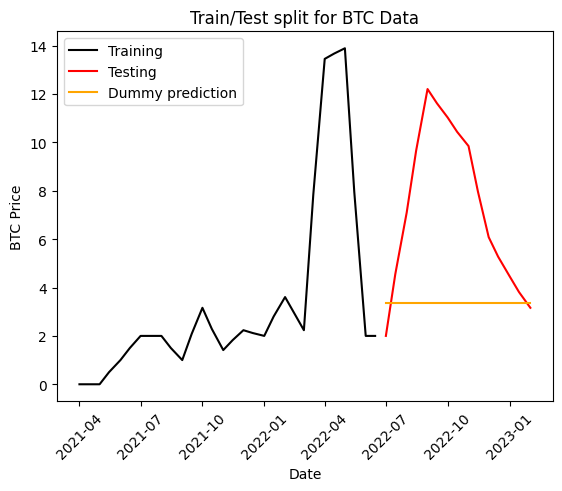

In [3]:
uno_punto=df['7-6']

train = uno_punto[uno_punto.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test = uno_punto[uno_punto.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]

dummy_pred=pd.Series(np.full((test.shape),train.mean(),dtype=float))
dummy_pred.index=test.index

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

In [4]:
dummy_rmse = np.sqrt(mean_squared_error(test.values, dummy_pred.values))
print("Dummy RMSE: ",dummy_rmse)

Dummy RMSE:  5.081689051481999


In [5]:
seasonal_orders=list(permutations_with_replacement(4, 5))
orders=list(permutations_with_replacement(3, 5))

In [6]:
cv_results=pd.DataFrame()
cv_results['seasonal_orders']=seasonal_orders
ordrs=np.tile(orders, (len(seasonal_orders), 1)).reshape((len(seasonal_orders),len(orders), 3)).tolist()
ordrs=[[tuple(el) for el in l] for l in ordrs]
cv_results['orders']=ordrs
cv_results=cv_results.explode(column='orders').sort_values(by=['seasonal_orders','orders']).reset_index(drop=True)
results=pd.Series(np.full((cv_results.shape[0],),100000,dtype=float))

In [9]:
cv_results_first_half=cv_results.iloc[:39000]
results_first_half=results[:39000]

9000 seconds

In [12]:
for (index, (s_ordr, ordr)) in cv_results_first_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_first_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [13]:
cv_results_first_half['results']=results_first_half

In [14]:
sorttt=cv_results_first_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [23]:
sorttt.tail(444)

,seasonal_orders,orders,results
38556,"(1, 1, 1, 5)","(2, 1, 1)",5.094094
38557,"(2, 1, 1, 4)","(1, 1, 3)",5.057235
38558,"(2, 1, 4, 5)","(4, 2, 2)",5.054987
38559,"(3, 1, 1, 4)","(2, 1, 1)",5.045390
38560,"(2, 1, 5, 5)","(4, 2, 2)",5.044992
...,...,...,...
38995,"(2, 2, 3, 4)","(3, 2, 2)",2.825920
38996,"(3, 2, 4, 4)","(3, 2, 2)",2.736549
38997,"(3, 2, 4, 4)","(2, 2, 3)",2.734832
38998,"(3, 2, 4, 4)","(2, 2, 2)",2.723330


In [24]:
sorttt.tail(444).to_csv('7-6'+'_half_1.csv')

In [25]:
cv_results_second_half=cv_results.iloc[39000:]
results_second_half=results[39000:]

In [27]:
cv_results_second_half

,seasonal_orders,orders
39000,"(3, 3, 3, 3)","(1, 1, 1)"
39001,"(3, 3, 3, 3)","(1, 1, 2)"
39002,"(3, 3, 3, 3)","(1, 1, 3)"
39003,"(3, 3, 3, 3)","(1, 1, 4)"
39004,"(3, 3, 3, 3)","(1, 1, 5)"
...,...,...
78120,"(5, 5, 5, 5)","(5, 5, 1)"
78121,"(5, 5, 5, 5)","(5, 5, 2)"
78122,"(5, 5, 5, 5)","(5, 5, 3)"
78123,"(5, 5, 5, 5)","(5, 5, 4)"


16400 seconds

In [28]:
for (index, (s_ordr, ordr)) in cv_results_second_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=100)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_second_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000


In [29]:
cv_results_second_half['results']=results_second_half
sorttt=cv_results_second_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [34]:
sorttt.tail(230)

,seasonal_orders,orders,results
38895,"(4, 1, 3, 4)","(1, 1, 1)",5.055971
38896,"(5, 1, 3, 5)","(1, 1, 2)",5.055754
38897,"(5, 1, 1, 5)","(4, 2, 2)",5.051299
38898,"(4, 1, 3, 4)","(1, 1, 3)",5.048010
38899,"(5, 1, 1, 5)","(1, 1, 2)",5.044397
...,...,...,...
39120,"(4, 2, 3, 4)","(3, 2, 3)",2.853228
39121,"(4, 2, 3, 4)","(1, 2, 2)",2.766972
39122,"(4, 2, 3, 4)","(1, 3, 2)",2.762400
39123,"(4, 2, 1, 4)","(1, 2, 3)",2.590951


In [35]:
sorttt.tail(230).to_csv('7-6'+'_half_2.csv')

## 6-5

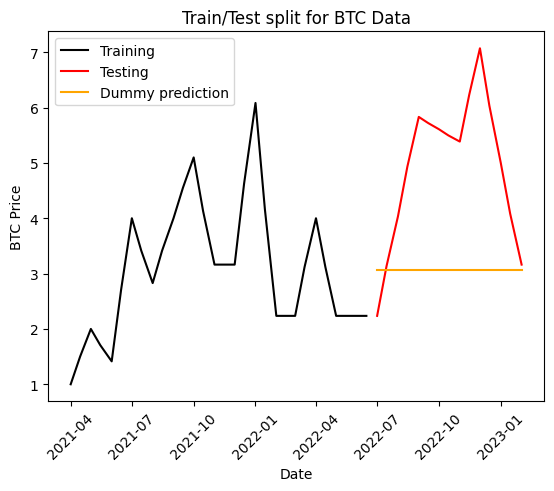

In [3]:
uno_punto=df['6-5']

train = uno_punto[uno_punto.index < pd.to_datetime("2022-07-01", format='%Y-%m-%d')]
test = uno_punto[uno_punto.index >= pd.to_datetime("2022-07-01", format='%Y-%m-%d')]

dummy_pred=pd.Series(np.full((test.shape),train.mean(),dtype=float))
dummy_pred.index=test.index

plt.plot(train, color = "black", label = 'Training')
plt.plot(test, color = "red", label = 'Testing')
plt.plot(dummy_pred, color = "orange", label = 'Dummy prediction')
plt.ylabel('BTC Price')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.title("Train/Test split for BTC Data");

In [4]:
dummy_rmse = np.sqrt(mean_squared_error(test.values, dummy_pred.values))
print("Dummy RMSE: ",dummy_rmse)

Dummy RMSE:  2.2677301677349284


In [5]:
seasonal_orders=list(permutations_with_replacement(4, 5))
orders=list(permutations_with_replacement(3, 5))

cv_results=pd.DataFrame()
cv_results['seasonal_orders']=seasonal_orders
ordrs=np.tile(orders, (len(seasonal_orders), 1)).reshape((len(seasonal_orders),len(orders), 3)).tolist()
ordrs=[[tuple(el) for el in l] for l in ordrs]
cv_results['orders']=ordrs
cv_results=cv_results.explode(column='orders').sort_values(by=['seasonal_orders','orders']).reset_index(drop=True)
results=pd.Series(np.full((cv_results.shape[0],),100000,dtype=float))

In [6]:
cv_results_first_half=cv_results.iloc[:39000]
results_first_half=results[:39000]

8333 seconds

In [7]:
for (index, (s_ordr, ordr)) in cv_results_first_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=80)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_first_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000


In [8]:
cv_results_first_half['results']=results_first_half
sorttt=cv_results_first_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [16]:
sorttt.tail(165)

,seasonal_orders,orders,results
38835,"(3, 1, 1, 5)","(1, 3, 3)",2.282991
38836,"(1, 1, 3, 5)","(4, 1, 4)",2.261981
38837,"(1, 1, 2, 5)","(2, 3, 4)",2.261089
38838,"(1, 1, 4, 5)","(3, 1, 1)",2.257386
38839,"(2, 2, 1, 5)","(4, 2, 3)",2.256172
...,...,...,...
38995,"(3, 1, 5, 5)","(3, 1, 1)",1.462060
38996,"(2, 1, 5, 5)","(4, 1, 2)",1.448294
38997,"(3, 1, 5, 5)","(4, 1, 4)",1.443139
38998,"(2, 1, 3, 5)","(4, 1, 4)",1.416954


In [17]:
sorttt.tail(165).to_csv('6-5'+'_half_1.csv')

In [18]:
cv_results_second_half=cv_results.iloc[39000:]
results_second_half=results[39000:]

15000 seconds

In [22]:
for (index, (s_ordr, ordr)) in cv_results_second_half.iterrows():
    if (index%1000==0):
        print(index)
    try:
        SARIMAXmodel = SARIMAX(train, order = ordr, seasonal_order=s_ordr, enforce_invertibility=False)
        SARIMAXmodel = SARIMAXmodel.fit(maxiter=80)
        srmx_y_pred = SARIMAXmodel.get_forecast(len(test.index))

        srmx_y_pred_df = srmx_y_pred.conf_int(alpha = 0.05) 
        srmx_y_pred_df["Predictions"] = SARIMAXmodel.predict(start = srmx_y_pred_df.index[0], end = srmx_y_pred_df.index[-1])
        results_second_half[index]=np.sqrt(mean_squared_error(test.values, srmx_y_pred_df["Predictions"]))
    except:
        continue

39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000


In [23]:
cv_results_second_half['results']=results_second_half
sorttt=cv_results_second_half.sort_values(by=['results','seasonal_orders','orders'], ascending=False).reset_index(drop=True)

In [27]:
sorttt.tail(170)

,seasonal_orders,orders,results
38955,"(4, 3, 1, 2)","(1, 1, 1)",2.274974
38956,"(4, 2, 2, 5)","(4, 2, 4)",2.259978
38957,"(4, 1, 3, 2)","(1, 3, 1)",2.241442
38958,"(3, 3, 4, 2)","(1, 2, 1)",2.236029
38959,"(5, 2, 2, 5)","(4, 2, 4)",2.231464
...,...,...,...
39120,"(5, 1, 1, 5)","(4, 1, 1)",1.298082
39121,"(4, 1, 5, 5)","(3, 1, 1)",1.284490
39122,"(4, 1, 2, 5)","(3, 1, 1)",1.269872
39123,"(5, 1, 5, 5)","(3, 1, 1)",1.265664


In [28]:
sorttt.tail(170).to_csv('6-5'+'_half_2.csv')